# Graph Visualizer

This workbook is used to test the GenerateDataset class by creating visual examples of the generated graphs

In [14]:
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import cdist
import tensorflow as tf
import matplotlib.pyplot as plt
from spektral.data import Dataset, Graph
%matplotlib inline

In [15]:
# Call MNIST pixel dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train.astype("float32")[...]/255.0, x_test.astype("float32")[...]/255.0

x_train = np.where(0.4 < x_train, 1, 0)
x_test = np.where(0.4 < x_test, 1, 0)

Enter the GenerateDataset class that is to be tested in the cell below

In [20]:
class GenerateDataset(Dataset):
    def __init__(self, n_samples, data, labels, **kwargs):
        self.n_samples = n_samples
        self.data = data
        self.labels = labels
        super().__init__(**kwargs)
    
    
    def read(self):
        def make_graph(ind):
            # Flatten the 28x28 grid into a 784 length array
            # This will be immediately undone in the next step but is being done here anyway as practice for future projects
            nodes = np.ndarray.flatten(self.data[ind])
            # Isolate the indices of the bright pixels
            bright = np.delete((np.where(nodes == 1)), -1)
            
            node_coords = []
            edges = []
            
            # The divmod function returns the coordinates from the index in the 784-array
            # he quotient yields the y-coordinate and the remainder yields the x-coordinate
            for i in range(len(bright)):
                node_coords.append(divmod(bright[i],28))
            
            # This creates a matrix of the distances between the bright pixels
            DistMat = cdist(node_coords, node_coords)
            
            # This step iterates over pairs of bright pixels, and the indices of the pairs are added to 'edges' if they are within a certain distance
            # Selecting 1.5 will result edges being created between bright pixels that are within each others' neighbourhood-of-8
            # (Diagonal distance is sqrt(2) =~ 1.414)
            # The distance can be increased accordingly to include larger neighbourhoods
            for i in range(len(node_coords)):
                for j in range(i+1, len(node_coords)):
                    if DistMat[i][j] <= 1.5:
                        edges.append((bright[i],bright[j]))
                                

            # Node features
            x = np.array(nodes, dtype=np.float32)

            # Edges
            r, c = zip(*edges)
            a = sp.csr_matrix((np.ones(len(r)), (np.array(r), np.array(c))), shape=(784, 784), dtype=np.float32)
            
            # Labels
            y = self.labels[ind]
            
            # Counters and Diagnostics
            if ind == 0:
                print("Graph generation started")
            elif (ind%100) == 0:
                print(ind, "graphs generated")
                
            ind +=1   
            
            return Graph(x=x, a=a, y=y)
                    
        # We must return a list of Graph objects
        return [make_graph(index) for index in range(self.n_samples)]

In [24]:
# Number of graphs to generate
n_graphs = 10

# Sample a random selection from the pixel dataset
idxs_train = np.random.permutation(len(x_train))
idxs_test = np.random.permutation(len(x_test))
idxs_train = idxs_train[:n_graphs]
idxs_test = idxs_test[:n_graphs]

(x_train_cut, y_train_cut), (x_test_cut, y_test_cut) = (x_train[idxs_train], y_train[idxs_train]), (x_test[idxs_test], y_test[idxs_test])

# Generate the graphs
data = GenerateDataset(n_graphs, x_train_cut, y_train_cut)

Graph generation started


In [37]:
#Pick a value index from the generated samples
graph_index = np.random.randint(0, n_graphs)

The visualisation code

Image label: 3


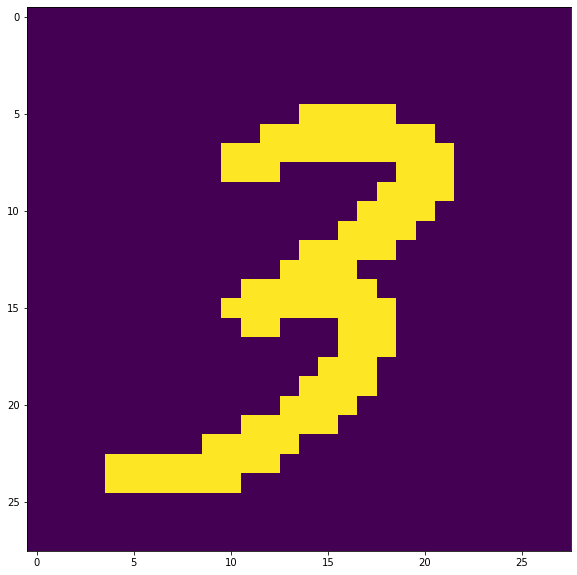

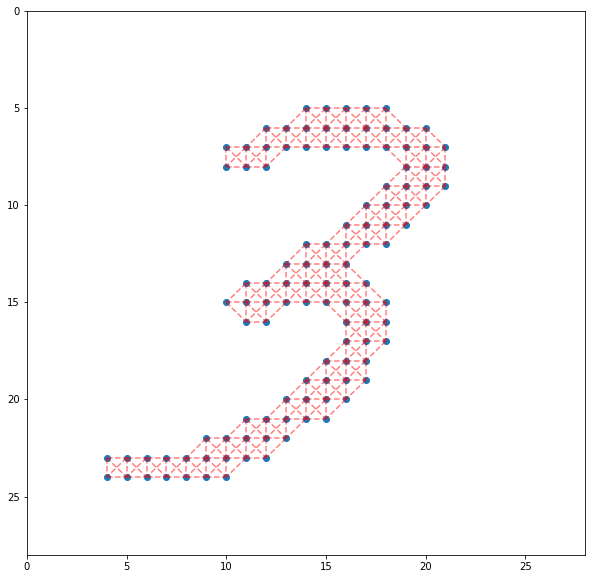

In [38]:
# Plot the input pixel image that is to be converted to a graph
plt.figure(figsize = (10,10))
plt.imshow(x_train_cut[graph_index].reshape(28,28))


# Graph visualization code
# This is meant to test the GenerateDataset class, so ONLY USE THE OUTPUT GRAPHS

nodes = data[graph_index].x
bright = np.delete((np.where(nodes == 1)), -1)
# BUG: not sure why there are still zeros after running np.delete
# use trim to cut them.
# I think there is a discrepency of avg 3 or 4 in number of edges in recreated adjacency matrix vs 
# graph adjency matrix because of this step
bright = np.trim_zeros(bright)
coords = []
edges = []

# Reverse engineer the GenerateDataset process
# I don't think there is a trivial way to retrieve edge coords using only the graph adjacency matrix 
# So use for loops to recreate the adjacency matrix with indices of nodes in bright pixel arrray 
# instead of the full 784 index array
for i in range(len(bright)):
    coords.append(divmod(bright[i],28))
    
DistMat = cdist(coords, coords)

for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        if DistMat[i][j] <= 1.5:
            edges.append((i,j))
            
r, c = zip(*edges)            
a = sp.csr_matrix((np.ones(len(r)), (np.array(r), np.array(c))), shape=(len(coords), len(coords)))
# o1, o2 are the indices of the start/end points of the edges in the node array
o1, o2 = a.nonzero()

                
nf = np.array(coords, dtype=np.float32)
y_c, x_c = zip(*nf)

print("Image label:", y_train_cut[graph_index])

fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim([0, 28])
plt.ylim([0, 28])
plt.scatter(x_c,y_c)

for i in range(len(o1)):
    x = (x_c[o1[i]],x_c[o2[i]])
    y = (y_c[o1[i]],y_c[o2[i]])
    ax.plot(x, y, 'r--', alpha=0.5)

plt.gca().invert_yaxis()
plt.show()